# Challenge - Support Vector Machine
## Recipe Ratings
For this challenge, we'll use the epicurious dataset, which has a collection of recipes, key terms and ingredients, and their ratings.

What we want to see is if we can use the provided features to predict the rating for each recipe. For someone writing a cookbook this could be really useful information that could help them choose which recipes to include because they're more likely to be enjoyed and therefore make the book more likely to be successful.

The dataset is [available on Kaggle](https://www.kaggle.com/hugodarwood/epirecipes).

Create a binary classifier and clean up the feature set. You can choose whether or not to include nutritional information, but try to cut your feature set down to the 30 most valuable features.

In [1]:
import numpy as np
import pandas as pd
import scipy
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

## Load the Dataset

In [2]:
recipes = pd.read_csv('https://tf-assets-prod.s3.amazonaws.com/tf-curric/data-science/epi_r.csv')

In [ ]:
print(len(recipes.columns))
list(recipes.columns)

In [7]:
recipes.head()

,title,rating,calories,protein,fat,sodium,#cakeweek,#wasteless,22-minute meals,3-ingredient recipes,...,yellow squash,yogurt,yonkers,yuca,zucchini,cookbooks,leftovers,snack,snack week,turkey
0,"Lentil, Apple, and Turkey Wrap",2.500,426.0,30.0,7.0,559.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1,Boudin Blanc Terrine with Red Onion Confit,4.375,403.0,18.0,23.0,1439.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,Potato and Fennel Soup Hodge,3.750,165.0,6.0,7.0,165.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,Mahi-Mahi in Tomato Olive Sauce,5.000,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,Spinach Noodle Casserole,3.125,547.0,20.0,32.0,452.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## Initial Exploration of Variable of Interest

In [6]:
recipes['rating'].describe()

count    20052.000000
mean         3.714467
std          1.340829
min          0.000000
25%          3.750000
50%          4.375000
75%          4.375000
max          5.000000
Name: rating, dtype: float64

In [20]:
print('Unique Ratings: ', list(np.unique(recipes['rating'])))

Unique Ratings:  [0.0, 1.25, 1.875, 2.5, 3.125, 3.75, 4.375, 5.0]


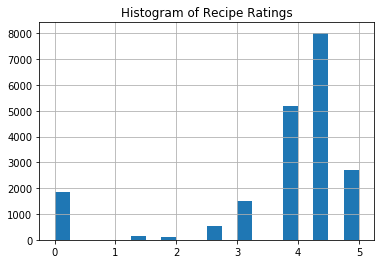

In [9]:
recipes['rating'].hist(bins=20)
plt.title('Histogram of Recipe Ratings')
plt.show()

In [21]:
#Do any columns contain NaNs?
# Proportion of nulls in column
print('Number of recipes: ', len(recipes))

null_prop = recipes.isnull().sum()/recipes.isnull().count()
null_prop[null_prop>0]

Number of recipes:  20052


calories    0.205316
protein     0.207560
fat         0.208608
sodium      0.205416
dtype: float64

In [24]:
list(null_prop[null_prop>0].index)

['calories', 'protein', 'fat', 'sodium']

In [ ]:
#Show rows that contain a NaN
recipes[list(null_prop[null_prop>0].index)][recipes[list(null_prop[null_prop>0].index)].isna().any(axis=1)]

In [27]:
#Since it looks like NaNs tend to exist in the same rows, let's drop those rows instead of the columns
recipes = recipes.dropna()

#Drop title column, as it doesn't provide useful information
recipes = recipes.drop('title', axis=1)

#Check if nulls have been properly dealt with
null_prop = recipes.isnull().sum()/recipes.isnull().count()
null_prop[null_prop>0]

Series([], dtype: float64)

## Split Data into Binary Classes

In [30]:
orig_rec = recipes.copy()

In [61]:
recipes = orig_rec.copy()

In [62]:
#high_rating > 3
#low_rating <= 3
recipes['rating'] = [1 if x > 3 else 0 for x in recipes['rating']]

In [38]:
features = recipes.drop(columns = ['rating'])
target = recipes['rating']

## Support Vector Classification (SVC)

In [44]:
from sklearn.svm import SVC
svc = SVC()
X = features.sample(frac=0.3, replace=True, random_state=1)
Y = target.sample(frac=0.3, replace=True, random_state=1)
svc.fit(X,Y)

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
  kernel='rbf', max_iter=-1, probability=False, random_state=None,
  shrinking=True, tol=0.001, verbose=False)

## Scatter Plot - Predictions vs. Actual

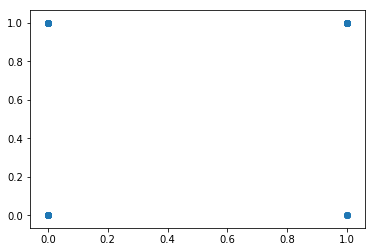

In [46]:
plt.figure()
plt.scatter(Y, svc.predict(X))
plt.show()

In [48]:
print('Accuracy: ', svc.score(X,Y))

Accuracy:  0.8974574490439168


## Double-Check Accuracy via Cross-Validation

In [50]:
from sklearn.model_selection import cross_val_score
# k-folds = 5
cross_score = cross_val_score(svc, X, Y, cv=5)
print(cross_score)

print('Average Cross-Validation Score: ', cross_score.mean())

[0.87815126 0.87815126 0.88445378 0.8802521  0.88433228]
Average Cross-Validation Score:  0.8810681370339933


When using all of the possible features, we get a very high classification accuracy of ~88%, via SVC. However, because we're using so many features, the runtime is very long. By removing the less-important features, we can keep accuracy high while reducing runtime.

## Iterative Models to Determine Important Features

In [54]:
len(recipes.columns)

679

In [93]:
#Remove any feature that only contain one unique value (i.e. NaN correlation to rating)
corrs = abs(recipes.corr())['rating']
drops = list(corrs[corrs.isnull()].index)

recipes = recipes.drop(drops, axis=1)
drops

['camping',
 'egypt',
 'frankenrecipe',
 'frittata',
 'grand marnier',
 'iowa',
 'jamaica',
 'las vegas',
 'mississippi',
 'new hampshire',
 'rosé',
 'waffle']

In [98]:
for i in [round(x,2) for x in np.arange(0.01, 1, 0.01)]:
    if (len(recipes.columns)>30):
        keep = list(recipes.corr().columns[list(np.where(abs(recipes.corr()['rating'])>i)[0])])
        recipes = recipes[keep]
        
        features = recipes.drop(columns = ['rating'])
        target = recipes['rating']
        
        svc = SVC()
        X = features.sample(frac=0.3, replace=True, random_state=1)
        Y = target.sample(frac=0.3, replace=True, random_state=1)
        svc.fit(X,Y)

        cross_score = cross_val_score(svc, X, Y, cv=5)
        print(cross_score)

        print('Average Cross-Validation Score: ', cross_score.mean())
        print(len(recipes.columns), ' features remaining!\n')
    else:
        break
        
print('Final feature list: ', list(recipes.columns))

[0.875      0.875      0.875      0.875      0.87592008]
Average Cross-Validation Score:  0.8751840168243954
353  features remaining!

[0.875      0.875      0.875      0.875      0.87592008]
Average Cross-Validation Score:  0.8751840168243954
197  features remaining!

[0.875      0.88445378 0.87605042 0.87710084 0.87592008]
Average Cross-Validation Score:  0.8777050252277567
109  features remaining!

[0.8802521  0.8802521  0.87920168 0.88340336 0.87381703]
Average Cross-Validation Score:  0.8793852556795588
70  features remaining!

[0.88445378 0.87920168 0.87920168 0.88340336 0.87276551]
Average Cross-Validation Score:  0.8798052028382332
43  features remaining!

[0.88760504 0.8802521  0.88340336 0.88235294 0.87381703]
Average Cross-Validation Score:  0.8814860960156933
28  features remaining!

Final feature list:  ['rating', 'alcoholic', 'bake', 'bitters', 'bon appétit', 'brandy', 'chile pepper', 'cocktail', 'cocktail party', 'condiment', 'créme de cacao', 'drink', 'fall', 'gin', 'ha

With a final feature list of 'alcoholic', 'bake', 'bitters', 'bon appétit', 'brandy', 'chile pepper', 'cocktail', 'cocktail party', 'condiment', 'créme de cacao', 'drink', 'fall', 'gin', 'harpercollins', 'house & garden', 'liqueur', 'non-alcoholic', 'peanut free', 'roast', 'rum', 'sauté', 'soy free', 'spirit', 'tree nut free', 'vegan', 'weelicious', and 'winter' (28 features total, including 'rating'), we get an average score of ~88% doing a 5-fold cross-validation. It's interesting to note that, in the end, none of the nutrition information variables were highly correlated with the ratings, but a large portion of the features in this set are related to alcohol, which possibly indicates that people who drink more are more likely to give higher ratings.